In [63]:
import matplotlib.pyplot as plt
import librosa as lb
import numpy as np
import pandas as pd
import yaml
import os

# Getting the values from config file
with open("../config.yaml") as file:
    config = yaml.safe_load(file)
    
# Important paths ;)
dirPath = config["paths"]["audioData"]
csvPath = dirPath + "/UrbanSound8K.csv"

# Number of MFC Coeffs
numOfMFCCoeffs = config["preprocessing"]["numOfMFCCoeffs"]

# Hop Length
hopLength = config["preprocessing"]["hopLength"]

In [64]:
# Load the csv file
df = pd.read_csv(csvPath)
df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


# 📂 Dataset Creation  

The existing `UrbanSound8K.csv` is **not needed** for our purpose in the current notebook.  

🔄 Instead, we will **create a new `dataset.csv`** in the same directory, which will contain:  

📌 **Columns:**  
- 🎵 **audio_file_path** – Path to the spectrogram image  
- 🎭 **class** – Corresponding class  

In [65]:
# Important paths ;)
dirPath = config["paths"]["audioData"]
csvPath = dirPath + "dataset.csv"

# Creating a new dataset
dataset = pd.DataFrame(columns = ["audio_file_path", "class"])

# Iterating the original dataset
for i in range(len(df)) :
    audio_file_path = os.path.join(dirPath, "fold"+str(df.loc[i]["fold"]), df.loc[i]["slice_file_name"])
    dataset.loc[i] = [audio_file_path, df.loc[i]["class"]]

In [66]:
# Saving the dataset
dataset.to_csv(os.path.join(dirPath, "dataset.csv"), index = False)

In [67]:
# Loading the new dataset again to check ;)
df = pd.read_csv(os.path.join(dirPath, "dataset.csv"))
df.head(10)

,audio_file_path,class
0,/home/g0d/Downloads/UrbanSound8K/fold5/100032-...,dog_bark
1,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
2,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
3,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
4,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
5,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
6,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
7,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
8,/home/g0d/Downloads/UrbanSound8K/fold5/100263-...,children_playing
9,/home/g0d/Downloads/UrbanSound8K/fold10/100648...,car_horn


# 🎛 Feature Extraction: Converting Raw Audio to Visual Representations

Now, We preprocess raw audio data by first converting it into audio waveform values
which later is used to generate different frequency based visual representations.

In [68]:
# Choosing a random sound file
randomRowNumber = np.random.randint(0,len(df)+1)
randomRow = df.iloc[randomRowNumber]
audioFilePath = randomRow["audio_file_path"]

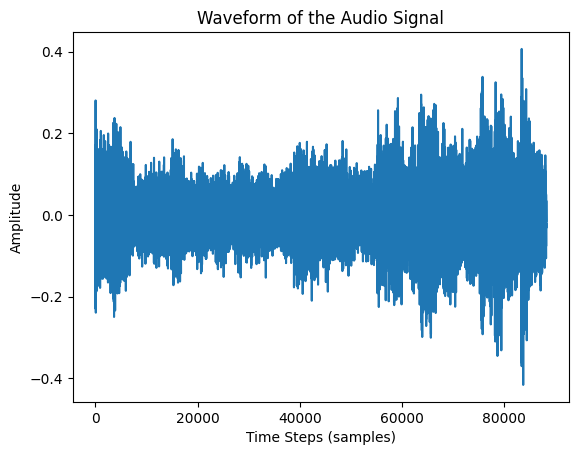

In [69]:
# Getting audio waveform and sampling rate i.e. Creating a numerical representation of given audio
audioWaveform, samplingRate = lb.load(audioFilePath)

# Plotting the waveform data ;)
plt.plot(audioWaveform)
plt.title("Waveform of the Audio Signal")
plt.xlabel("Time Steps (samples)")
plt.ylabel("Amplitude")
plt.show()

# 1️⃣ STFT Spectrogram
Generated using: Short-Time Fourier Transform (STFT) of Audio Waveform<br>
Function: librosa.stft(y=y) <br>
Graphing Function: librosa.display.specshow(dB_values, x_axis = "time", y_axis = "log")
X-axis: Time (seconds) <br>
Y-axis: Frequency (Hz, log scale) <br>
Color intensity: Magnitude (in dB) <br>
Purpose: Shows how different frequencies evolve over time in an audio signal.

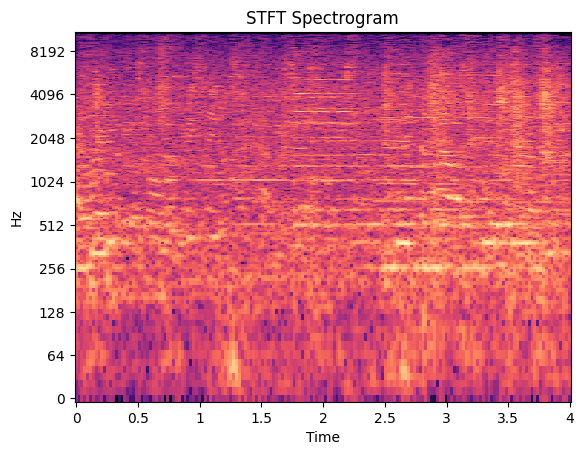

In [70]:
"""
Notice the key difference 
1> librosa.load() => Time-Domain representation of the audio. It gives us a one-dimensional array of amplitude values at each point in time, which is the raw waveform.
2> librosa.stft() => Frequency-Domain representation of the audio. It gives us a complex matrix representing the frequency components of the audio signal at each short time frame.
"""

A = lb.stft(y = audioWaveform) # A = Amplitudes

# A is a Complex Matrix => To extract meaningful frequency content, We take absolute/magnitude of it.
A = np.abs(A)

# Now, A represent magnitudes/amplitudes only. Convert them to dB values. Why? We (Humans) perceive sound in log scale. Also, It's easy to visualize amplitude differences in log scale.
# dB = 20 * log10(A / A_ref)
# Here,A_ref = np.max meaning Max(A)
dB_values = lb.amplitude_to_db(A, ref = np.max)

lb.display.specshow(dB_values, x_axis = "time", y_axis = "log")
plt.title("STFT Spectrogram")
plt.show()

# 2️⃣ Mel Spectrogram
Generated using: Mel filter banks applied to STFT values<br>
Function: librosa.feature.melspectrogram(y=y, sr=sr) <br>
Graphing function: librosa.display.specshow(S_dB, x_axis="time", y_axis="mel") <br>
X-axis: Time (seconds) <br>
Y-axis: Mel frequency bins (log scale) <br>
Color intensity: Power (in dB) <br>
Purpose: A human-perceived frequency representation, useful for speech/music analysis.

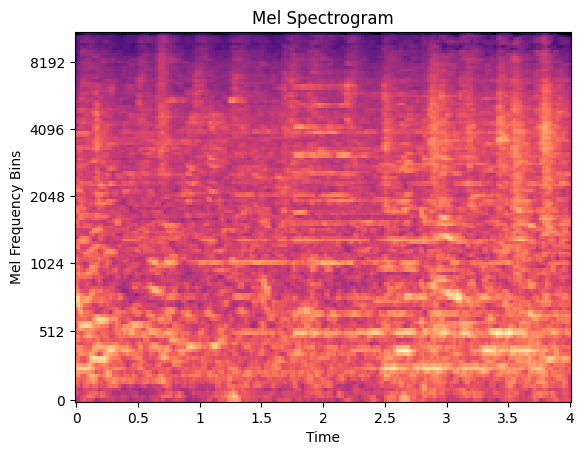

In [71]:
"""
The Mel spectrogram represents the power of different frequency bands in the audio signal. 
It uses the Mel scale, which is more aligned with how humans perceive sound frequencies.
"""

P = lb.feature.melspectrogram(y = audioWaveform, sr = samplingRate, hop_length = hopLength)

# Now, P represent raw power values. Convert them to dB values.
# Why? We (Humans) perceive sound in log scale (So it mimics human hearing).
# Also, It's easy to visualize amplitude differences in log scale.

# dB = 10 * log10(P / P_ref)
# Here, P_ref = np.max meaning Max(P)
dB_values = lb.power_to_db(P, ref = np.max)

lb.display.specshow(dB_values, x_axis = "time", y_axis = "mel")
plt.title("Mel Spectrogram")
plt.ylabel("Mel Frequency Bins")
plt.show()

# 3️⃣ MFCCs (Mel-Frequency Cepstral Coefficients)
Generated using: Applying log transformation (conversion to dB) to Mel Spectrogram values and then taking Discrete Cosine Transform (DCT) to extract only the most important features <br> 
Function: librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40) <br>
Graphing function: librosa.display.specshow(mfccs, x_axis="time") <br>
X-axis: Time (seconds) <br>
Y-axis: MFCC coefficients (1 to n_mfcc) <br>
Color intensity: MFCC value <br>
Purpose: Extracts only the most important frequency features.

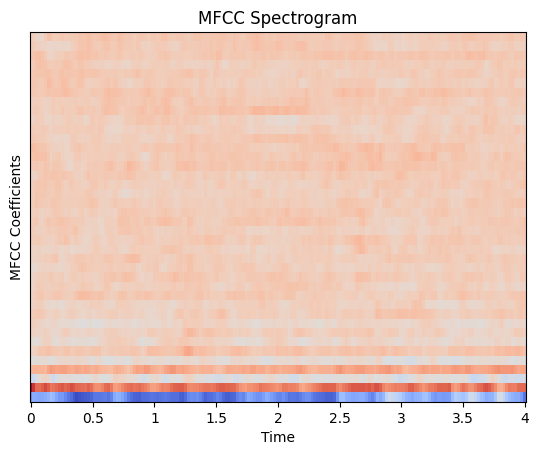

In [72]:
mfcc = lb.feature.mfcc(y = audioWaveform, sr = samplingRate, n_mfcc = numOfMFCCoeffs)

"""
mfcc = 2D array (matrix) representing the Mel-Frequency Cepstral Coefficients (MFCCs) of an audio signal.
Dimensions: (n_mfcc, T) where
    n_mfcc is the number of MFCCs (Mel Frequency Cepstral Coefficients) we want to extract.
    T is the number of time frames or segments (essentially the number of time steps over which the MFCCs are computed).

Each column of the MFCC array represents the MFCCs at a particular time frame.
Each row corresponds to one of the n_mfcc coefficients. 
"""

lb.display.specshow(mfcc, x_axis = "time")
plt.title("MFCC Spectrogram")
plt.ylabel("MFCC Coefficients")
plt.show()

# We will move forward with Mel Spectrograms due to the following reasons:
## 1. Better Visualization of Frequency Content:
Mel Spectrogram is a direct visualization of the audio signal's frequency content.

## 2. Intuitive Representation:
Mel Spectrogram represents frequencies on a Mel scale, which approximates the human ear’s perception of sound.

## Removing unnecessary details from graph like axes, title etc.
### This image will be fed to the model.

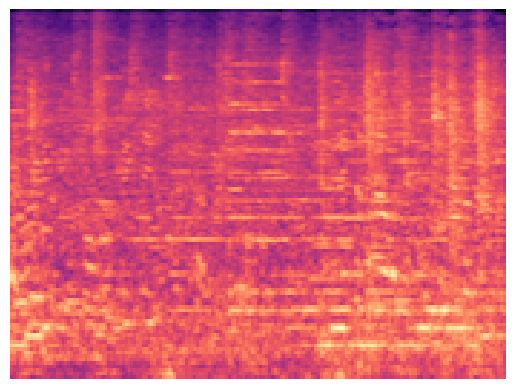

In [73]:
P = lb.feature.melspectrogram(y = audioWaveform, sr = samplingRate, hop_length = hopLength)

dB_values = lb.power_to_db(P, ref = np.max)

lb.display.specshow(dB_values, x_axis = "time", y_axis = "mel")
plt.axis("off")
plt.show()